# Gold Price Forecasting Study
## Model Implementation and Comparison

This notebook implements and compares three forecasting models:
1. ARIMA: Basic time series forecasting
2. SARIMA: Incorporating seasonal patterns (5-day business week)
3. SARIMAX: Including both seasonal patterns and exogenous variables

We'll analyze their performance across multiple dimensions:
- Forecast accuracy at different time horizons (1, 5, and 30 days)
- Impact of incorporating seasonality
- Effect of including exogenous variables

In [1]:
# Standard imports
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Constants
attribute_to_predict = 'gold_Close'
exog_vars = ['crude_oil_Price', 'sp500_Price', 'silver_Price', 'dollar_rate_Price', 'cpi_CPI', 'ppi_PPI', 'is_holiday']
horizons = [1, 5, 30]

## Data Preparation
Loading and preparing the dataset for analysis.

In [2]:
# Read the dataset
all_data = pd.read_csv('all_data.csv')
all_data = all_data.dropna()
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data.set_index('Date', inplace=True)
full_df = all_data[[attribute_to_predict] + exog_vars]

# Verify no missing values
print("Missing values after cleaning:")
print(full_df.isnull().sum())
full_df.head()

Missing values after cleaning:
gold_Close           0
crude_oil_Price      0
sp500_Price          0
silver_Price         0
dollar_rate_Price    0
cpi_CPI              0
ppi_PPI              0
is_holiday           0
dtype: int64


,gold_Close,crude_oil_Price,sp500_Price,silver_Price,dollar_rate_Price,cpi_CPI,ppi_PPI,is_holiday
Date,,,,,,,,
2014-01-07,118.820000,93.67,1837.9,19.787,80.83,235.288,203.8,0
2014-01-08,118.120003,92.33,1837.5,19.539,81.02,235.288,203.8,0
2014-01-09,118.459999,91.66,1838.1,19.683,81.00,235.288,203.8,0
2014-01-10,120.260002,92.72,1842.4,20.223,80.66,235.288,203.8,0
2014-01-13,121.019997,91.80,1819.2,20.385,80.51,235.288,203.8,0


## Train-Test Split
Implementing a train-test split for model evaluation on multiple periods and prediction window sizes.

In [7]:
def slice_data(full_df: DataFrame, train_start_id: int, split_id: int, test_window_size: int, print_periods=False, include_exog=False):
    train_df = full_df.iloc[train_start_id:split_id]
    test_df = full_df.iloc[split_id:split_id + test_window_size]
    
    if print_periods: 
        print('Train period:', train_df.index[0], 'to', train_df.index[-1])
        print('Test period:', test_df.index[0], 'to', test_df.index[-1])
    
    if not include_exog:
        return train_df, test_df
    else:
        exog_train = full_df.shift(test_window_size).iloc[train_start_id:split_id]
        exog_test = full_df.shift(test_window_size).iloc[split_id:split_id + test_window_size]
        return train_df, test_df, exog_train, exog_test

In [4]:
# Test the logic and make sure train and test periods are correct
for win_size in horizons:
    print(f"\nSplitting data for {win_size}-day forecast:")
    split_id = int(len(all_data) * 0.8)
    start_id = win_size
    while split_id + win_size <= len(all_data):
        _, _ = slice_data(full_df, start_id, split_id, win_size, print_periods=(0<=start_id <=win_size))
        start_id += win_size
        split_id += win_size


Splitting data for 1-day forecast:
Train period: 2014-01-08 00:00:00 to 2022-07-20 00:00:00
Test period: 2022-07-21 00:00:00 to 2022-07-21 00:00:00

Splitting data for 5-day forecast:
Train period: 2014-01-14 00:00:00 to 2022-07-20 00:00:00
Test period: 2022-07-21 00:00:00 to 2022-07-27 00:00:00

Splitting data for 30-day forecast:
Train period: 2014-02-17 00:00:00 to 2022-07-20 00:00:00
Test period: 2022-07-21 00:00:00 to 2022-08-31 00:00:00


## Model Parameter Selection
Exploring the data of the selected attribute to choose the appropriate parameters for ARIMA, SARIMA, and SARIMAX models.

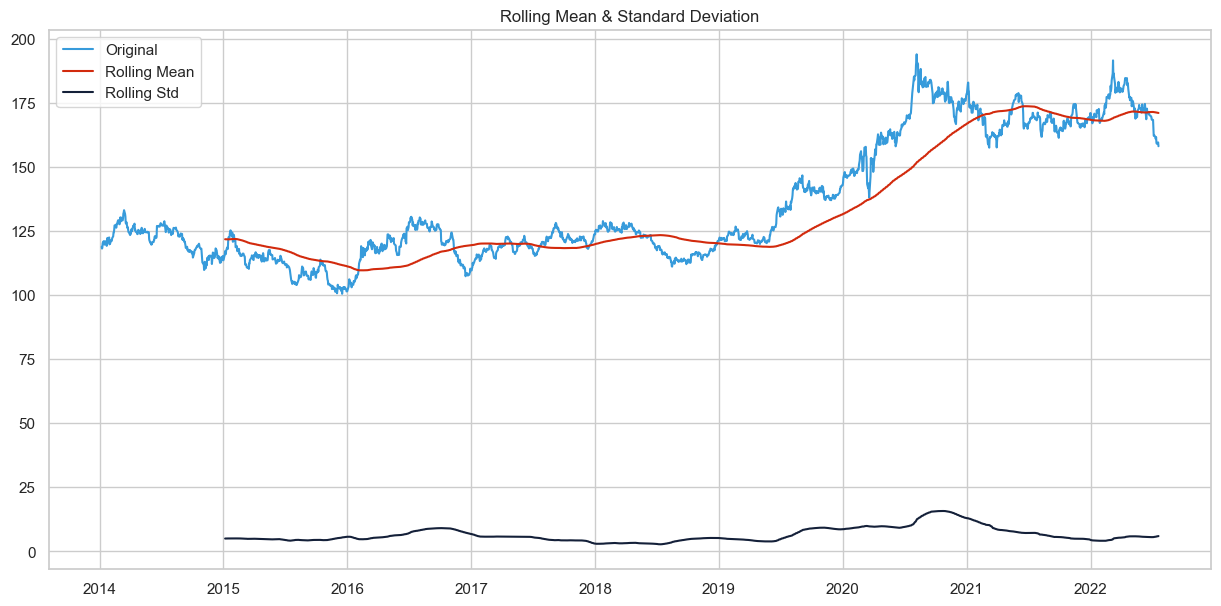

In [6]:
#Determine rolling statistics
df_for_plotting, _, exog_train, _ = slice_data(full_df, 0, int(len(all_data) * 0.8), len(all_data), include_exog=True)
df_for_plotting["rolling_avg"] = df_for_plotting[attribute_to_predict].rolling(window=265).mean() #window size 265 denotes 2655 days, giving rolling mean at yearly level
df_for_plotting["rolling_std"] = df_for_plotting[attribute_to_predict].rolling(window=265).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_for_plotting[attribute_to_predict], color='#379BDB', label='Original')
plt.plot(df_for_plotting["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_for_plotting["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_for_plotting[attribute_to_predict], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -1.132242
p-value                           0.702045
#Lags Used                        0.000000
Number of Observations Used    2289.000000
Critical Value (1%)              -3.433210
Critical Value (5%)              -2.862804
Critical Value (10%)             -2.567443
dtype: float64


P value is pretty high, so we can't reject the null hypothesis. The data on its own is non-stationary, meaning that we will have to differentiate it. We'll test the auto_arima function for determining the best parameters for ARIMA, SARIMA, and SARIMAX models.

Best ARIMA order: (0, 1, 0)
Best Seasonal order: (0, 0, 0, 0)


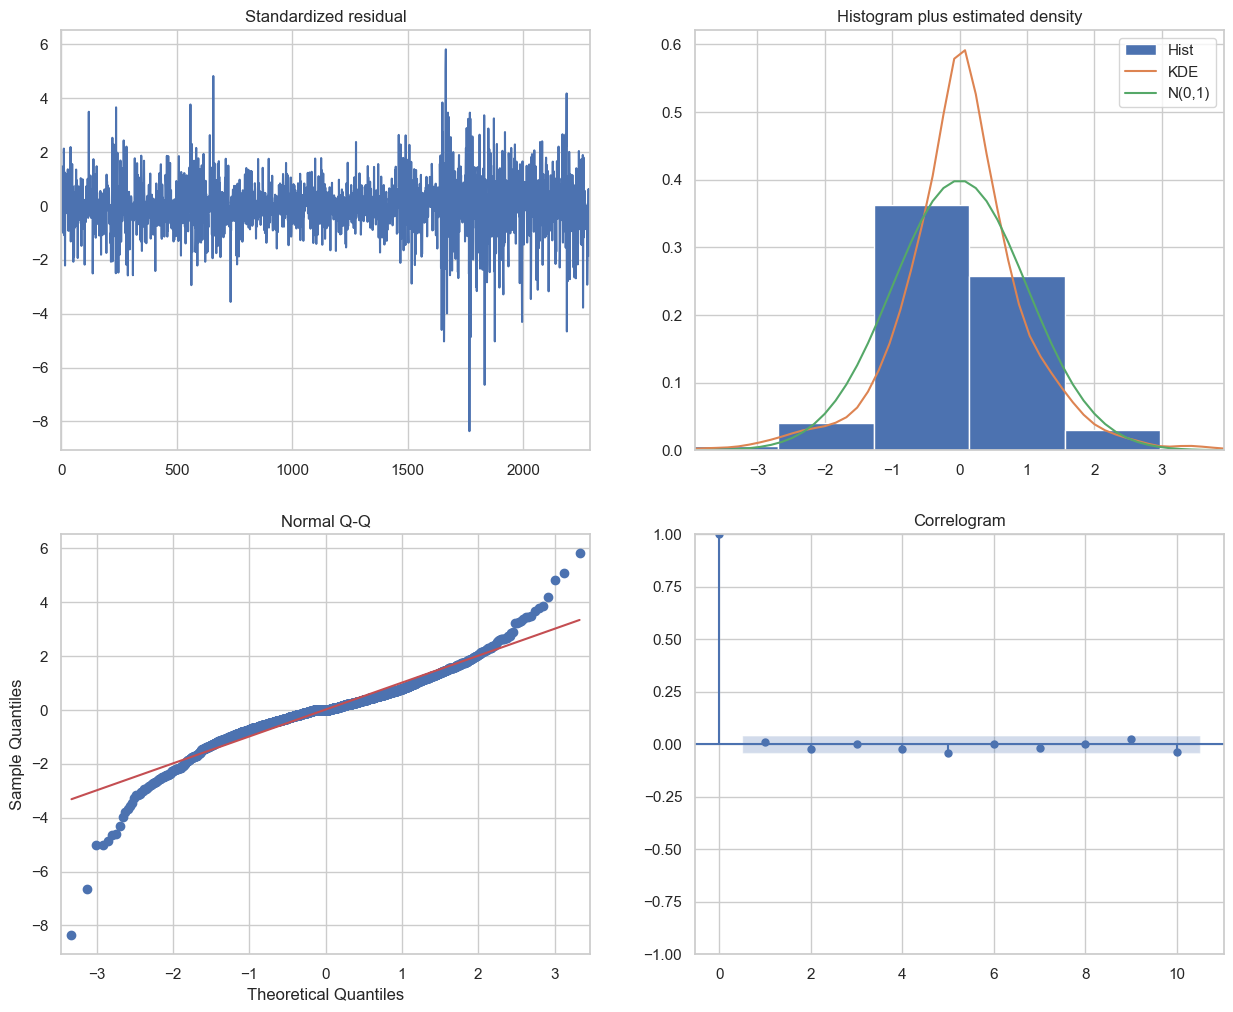

In [8]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df_for_plotting[attribute_to_predict], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print("Best ARIMA order:", ARIMA_model.order)              # For (p, d, q)
print("Best Seasonal order:", ARIMA_model.seasonal_order)  # For (P, D, Q, m)
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Best SARIMA order: (2, 0, 1)
Best Seasonal order: (2, 1, 0, 5)


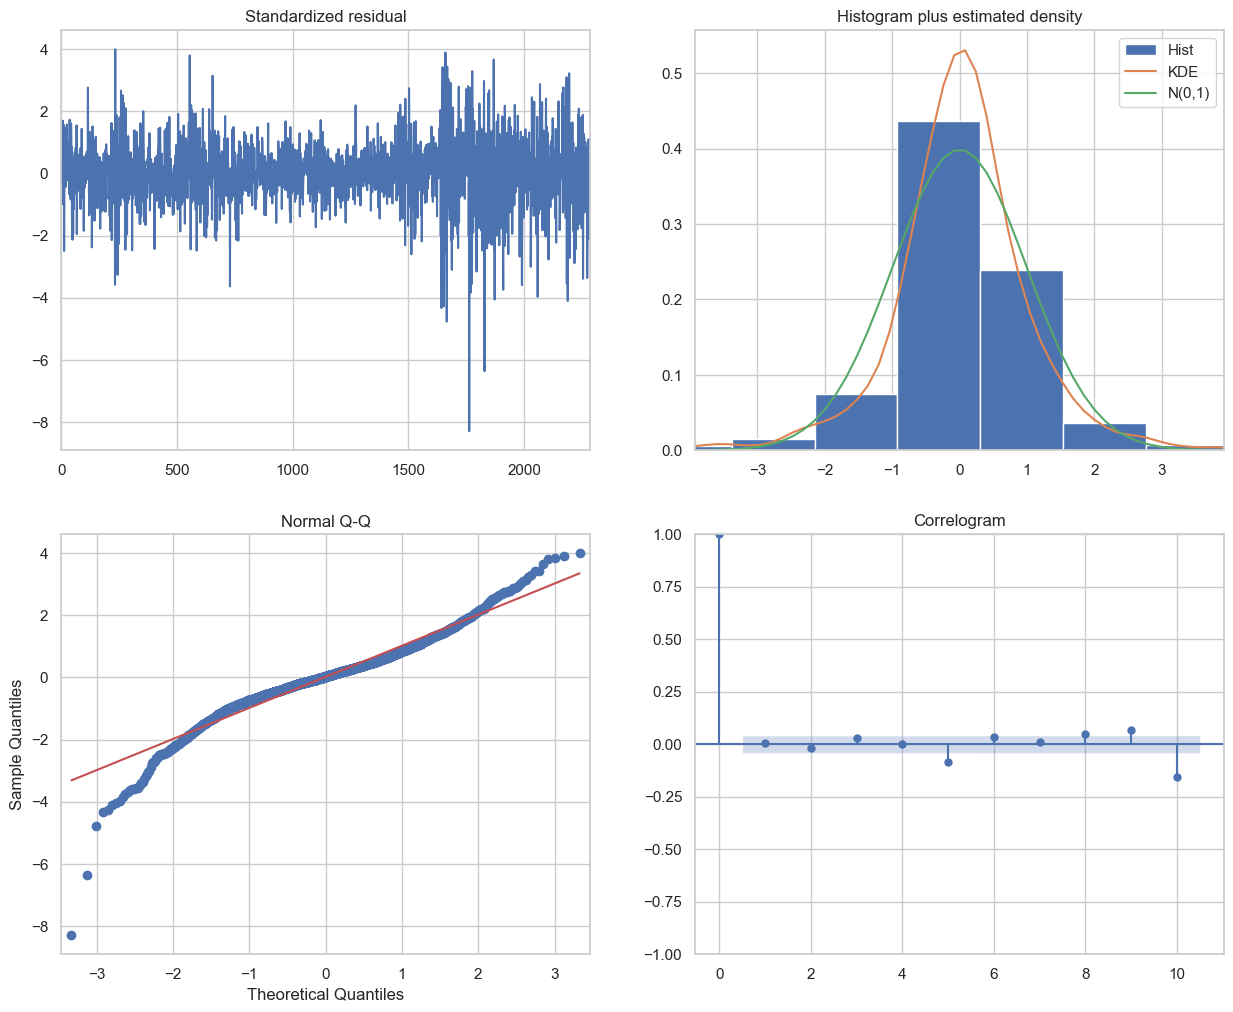

In [9]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df_for_plotting[attribute_to_predict], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=5, #5 is the frequncy of the cycle (working week)
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print("Best SARIMA order:", SARIMA_model.order)              # For (p, d, q)
print("Best Seasonal order:", SARIMA_model.seasonal_order)  # For (P, D, Q, m)
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Best SARIMAX order: (2, 0, 1)
Best Seasonal order: (2, 1, 0, 5)


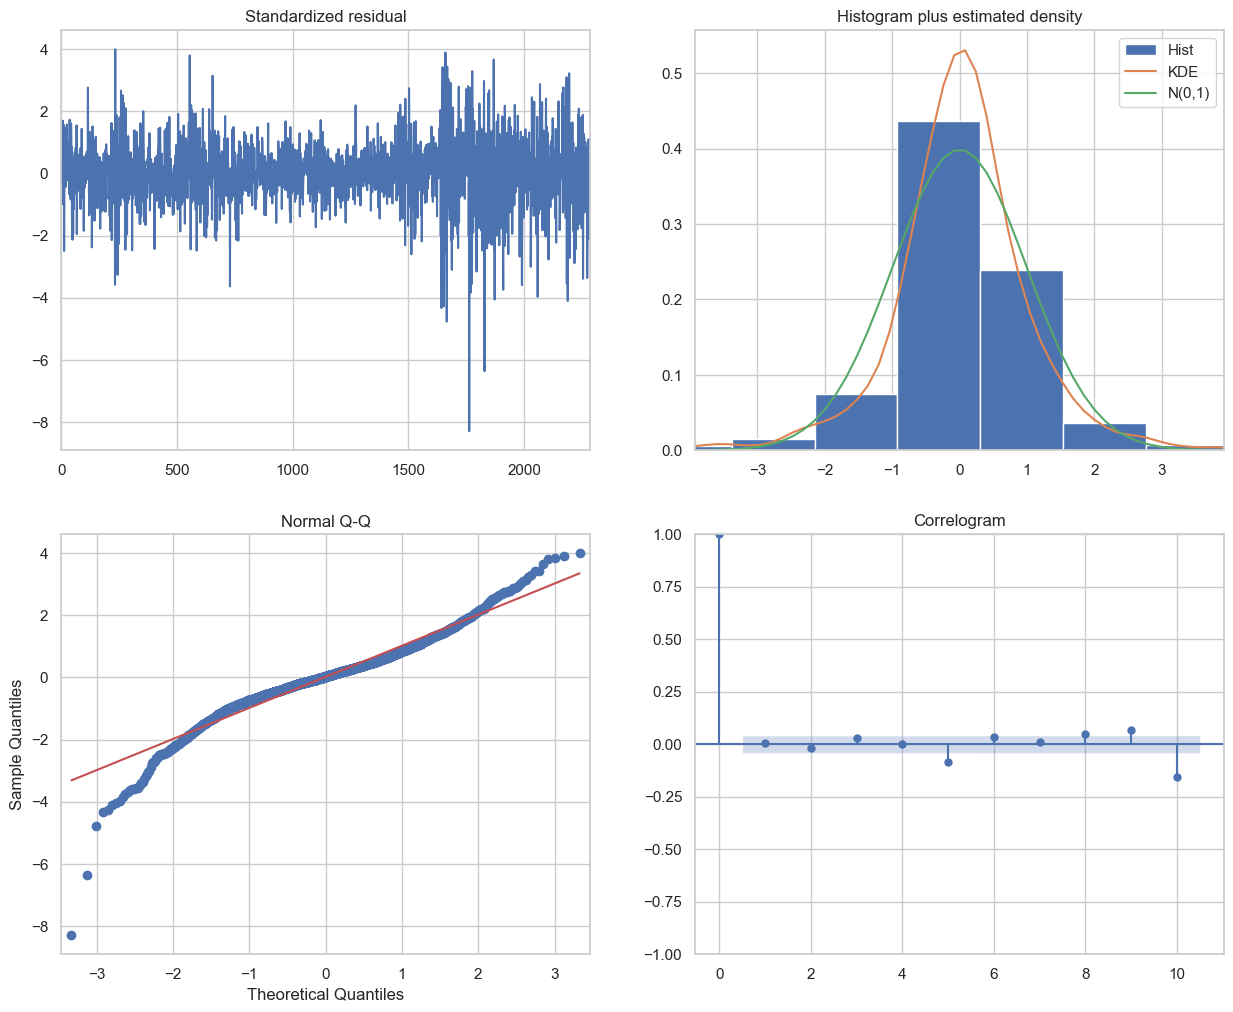

In [8]:
# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_for_plotting[attribute_to_predict], 
                           exogenous=exog_train[exog_vars],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=5,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print("Best SARIMAX order:", SARIMAX_model.order)              # For (p, d, q)
print("Best Seasonal order:", SARIMAX_model.seasonal_order)  # For (P, D, Q, m)
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

## Model Implementation
Implementing ARIMA, SARIMA, and SARIMAX models with appropriate parameters.

In [9]:
def train_models(train_df: DataFrame, exog_train_df: DataFrame, flags=[True, True, True]) -> tuple:
    """
    Train ARIMA, SARIMA, and SARIMAX models on the provided training data.
    Models will train over ALL passed train data.
    Models configuration is based on the best parameters found using auto_arima.
    :return: the trained models object for each model
    """
    # Implement ARIMA model
    arima_results = None
    if flags[0]:
        arima_model = ARIMA(train_df[attribute_to_predict], order=ARIMA_model.order)
        arima_results = arima_model.fit()
    
    # Implement SARIMA model
    sarima_results = None
    if flags[1]:
        sarima_model = SARIMAX(train_df[attribute_to_predict],
                              order=SARIMA_model.order,
                              seasonal_order=SARIMA_model.seasonal_order)
        sarima_results = sarima_model.fit()
    
    # Implement SARIMAX model
    sarimax_results = None
    if flags[2]:
        sarimax_model = SARIMAX(train_df[attribute_to_predict],
                               exog=exog_train_df[exog_vars],
                               order=SARIMAX_model.order,
                               seasonal_order=SARIMAX_model.seasonal_order)
        sarimax_results = sarimax_model.fit()
    
    return arima_results, sarima_results, sarimax_results

def create_forecasts(arima_trained, sarima_trained, sarimax_trained,
                     test_df: DataFrame, test_window_size, exog_test_df: DataFrame, flags=[True, True, True]) -> tuple:
    # ARIMA forecasts
    arima_forecast = None
    if flags[0]:
        arima_forecast = pd.Series(
            arima_trained.forecast(steps=test_window_size))
        arima_forecast.index = test_df.index

    # SARIMA forecasts
    sarima_forecast = None
    if flags[1]:
        sarima_forecast = pd.Series(
            sarima_trained.forecast(steps=test_window_size))
        sarima_forecast.index = test_df.index

    # SARIMAX forecasts
    sarimax_forecast = None
    if flags[2]:
        sarimax_forecast = pd.Series(
            sarimax_trained.forecast(steps=test_window_size, exog=exog_test_df[exog_vars]))
        sarimax_forecast.index = test_df.index
    
    return arima_forecast, sarima_forecast, sarimax_forecast
    

Examining what are the coefficients of each attribute in the SARIMAX model

In [25]:
train_df, test_df, exog_train_df, _ = slice_data(full_df, 5, int(len(all_data) * 0.8), 5, include_exog=True)
arima_results, sarima_results, sarimax_results = train_models(train_df, exog_train_df)
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         gold_Close   No. Observations:                 2285
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 5)   Log Likelihood               -3973.318
Date:                            Sat, 09 Nov 2024   AIC                           7972.635
Time:                                    20:32:02   BIC                           8047.150
Sample:                                         0   HQIC                          7999.814
                                           - 2285                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
crude_oil_Price       0.0075      0.010      0.749      0.454      -0.012       0.027
sp500_Price   

## Forecast Generation
Generating multiple forecasts for different time horizons (1, 7, and 30 days).

In [29]:
all_forecasts_dict = {}
for win_size in horizons:
    print(f"Running for configured {win_size}-day forecast:")
    split_id = int(len(all_data) * 0.8)
    start_id = win_size
    while split_id + win_size <= len(all_data):
        curr_train_df, curr_test_df, curr_exog_train, curr_exog_test = slice_data(full_df, start_id, split_id, win_size, print_periods=(0<=start_id <=win_size), include_exog=True)
        arima_results, sarima_results, sarimax_results = train_models(curr_train_df, curr_exog_train)
        arima_forecast, sarima_forecast, sarimax_forecast = create_forecasts(arima_results, sarima_results, sarimax_results, curr_test_df, win_size, curr_exog_test)
        if start_id == win_size:
            accumulated_arima_forecast = arima_forecast
            accumulated_sarima_forecast = sarima_forecast
            accumulated_sarimax_forecast = sarimax_forecast
        else:
            accumulated_arima_forecast = pd.concat([accumulated_arima_forecast, arima_forecast])
            accumulated_sarima_forecast = pd.concat([accumulated_sarima_forecast, sarima_forecast])
            accumulated_sarimax_forecast = pd.concat([accumulated_sarimax_forecast, sarimax_forecast])
        start_id += win_size
        split_id += win_size
        # if not (0<=start_id <=win_size):
        #     break
    print(f"Saving forecasts for {win_size}-day forecast...")
    all_window_forecasts = pd.concat([accumulated_arima_forecast, accumulated_sarima_forecast, accumulated_sarimax_forecast], axis=1)
    all_forecasts_dict[win_size] = all_window_forecasts

Running for configured 1-day forecast:
Train period: 2014-01-08 00:00:00 to 2022-07-20 00:00:00
Test period: 2022-07-21 00:00:00 to 2022-07-21 00:00:00
Saving forecasts for 1-day forecast...
Running for configured 5-day forecast:
Train period: 2014-01-14 00:00:00 to 2022-07-20 00:00:00
Test period: 2022-07-21 00:00:00 to 2022-07-27 00:00:00
Saving forecasts for 5-day forecast...
Running for configured 30-day forecast:
Train period: 2014-02-17 00:00:00 to 2022-07-20 00:00:00
Test period: 2022-07-21 00:00:00 to 2022-08-31 00:00:00
Saving forecasts for 30-day forecast...


In [30]:
# Save to a .pkl file
# with open('results_dict.pkl', 'wb') as f:
#     pickle.dump(all_forecasts_dict, f)

In [36]:
with open('results_dict.pkl', 'rb') as f:
    sarimax_forecasts_dict = pickle.load(f)

## Results Visualization
Comparing forecasts from different models with actual values.

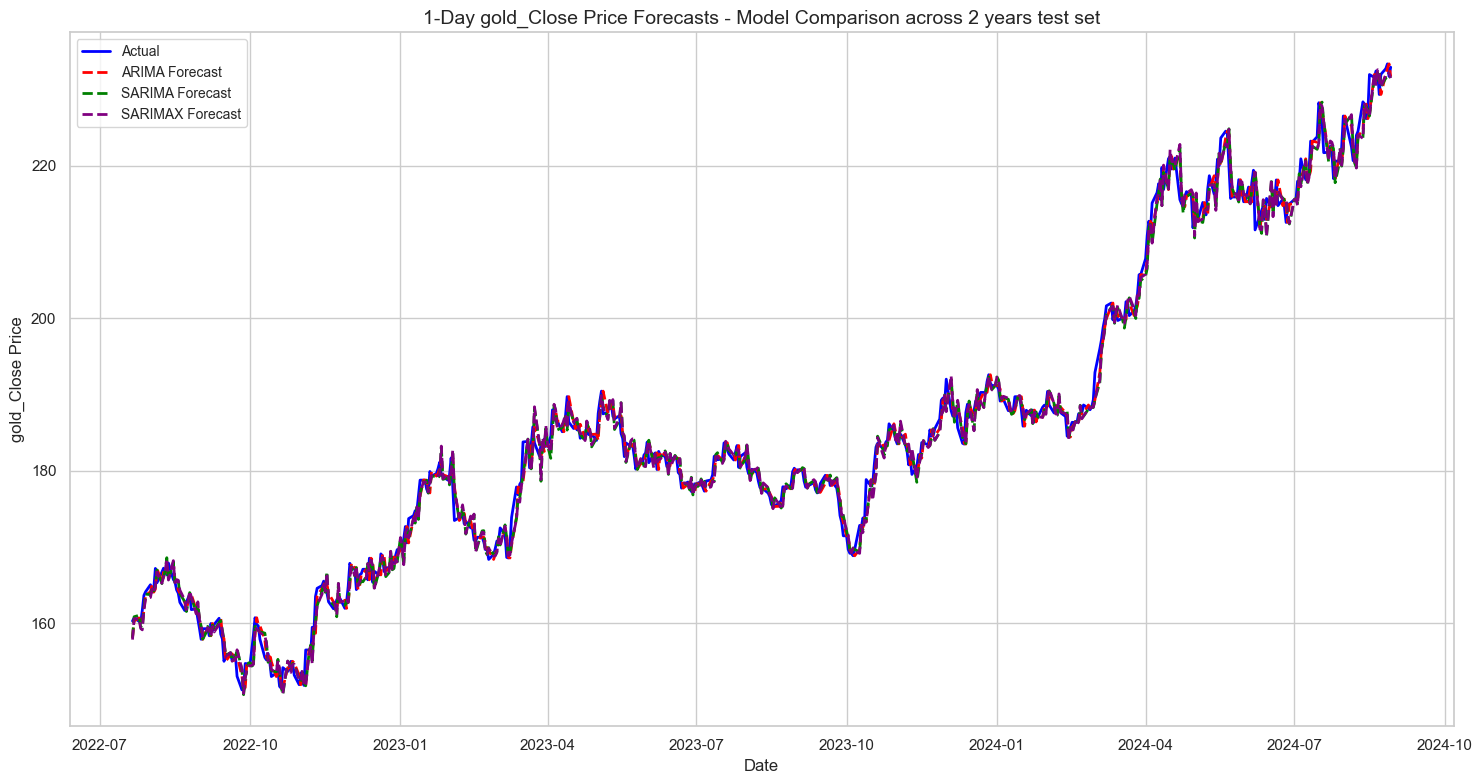

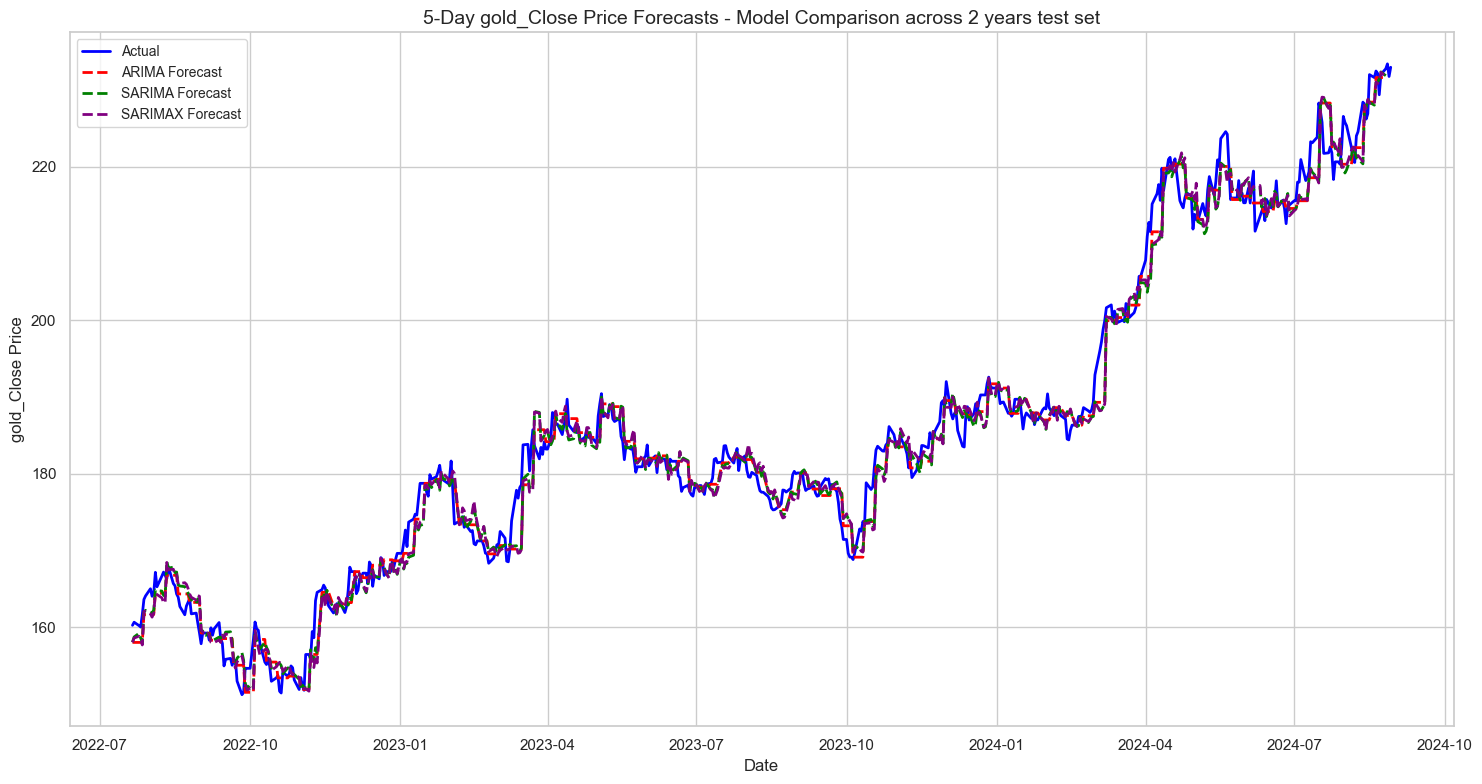

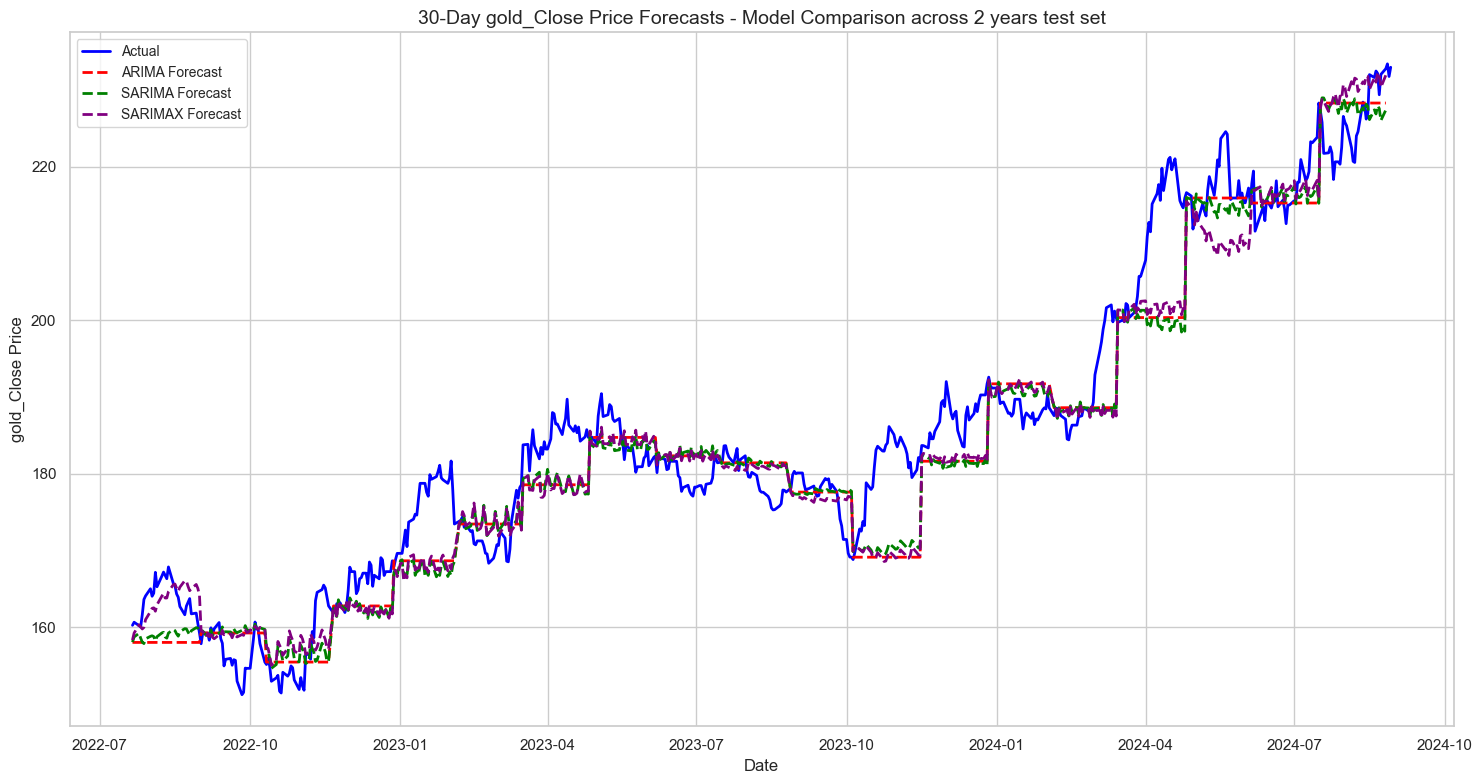

In [45]:
# Create comparison plots for each horizon
colors = {'ARIMA': 'red', 'SARIMA': 'green', 'SARIMAX': 'purple'}
_, true_test_df = slice_data(full_df, 0, int(len(all_data) * 0.8), len(all_data))

for horizon in horizons:
    plt.figure(figsize=(15, 8))

    # Plot actual values
    actual = true_test_df[attribute_to_predict]
    plt.plot(actual.index, actual.values, label='Actual', color='blue', linewidth=2)

    # Load and plot forecasts
    for model, color in colors.items():
        forecast_data = all_forecasts_dict[horizon][model]
        plt.plot(forecast_data.index, forecast_data.values,
                label=f'{model} Forecast',
                color=color,
                linestyle='--',
                linewidth=2)

    plt.title(f'{horizon}-Day {attribute_to_predict} Price Forecasts - Model Comparison across 2 years test set', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{attribute_to_predict} Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

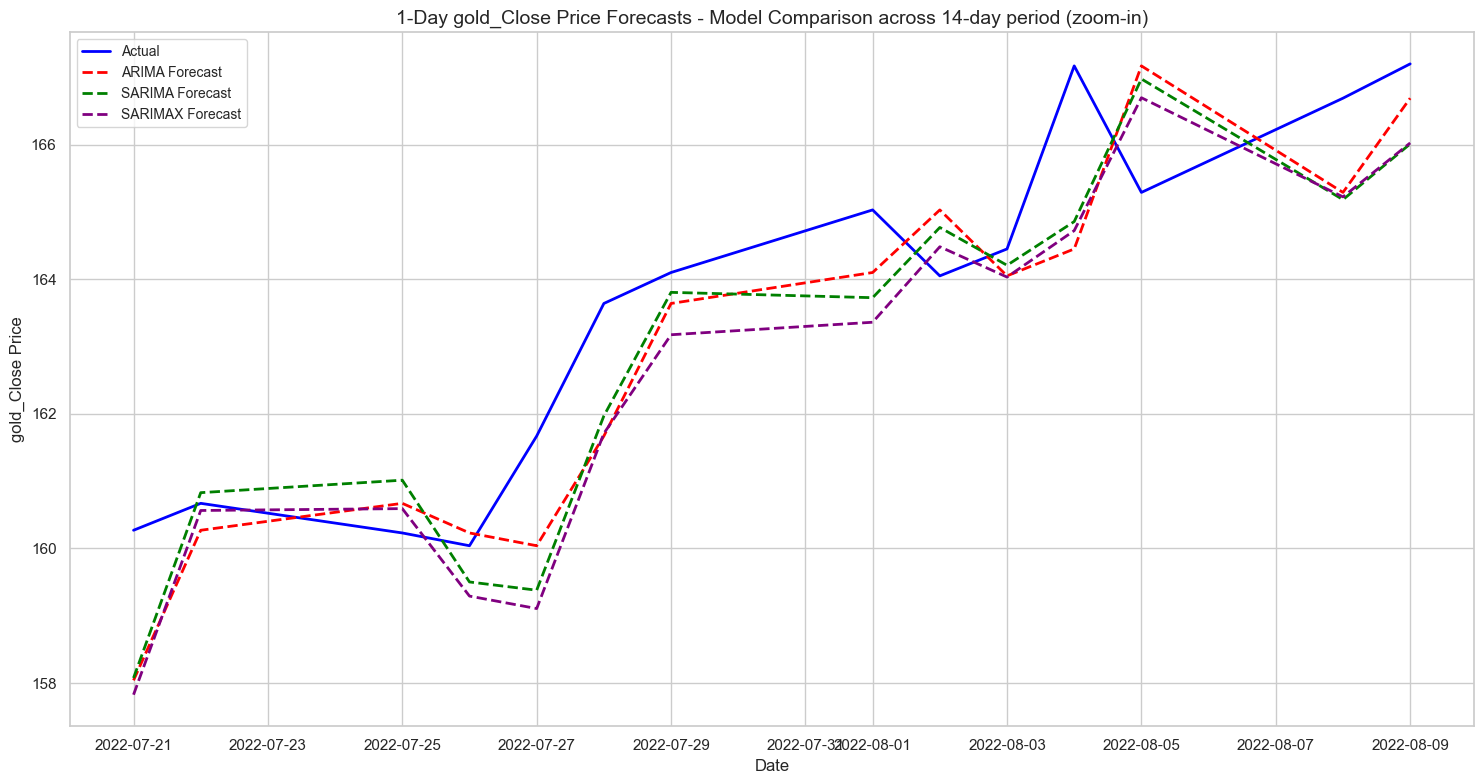

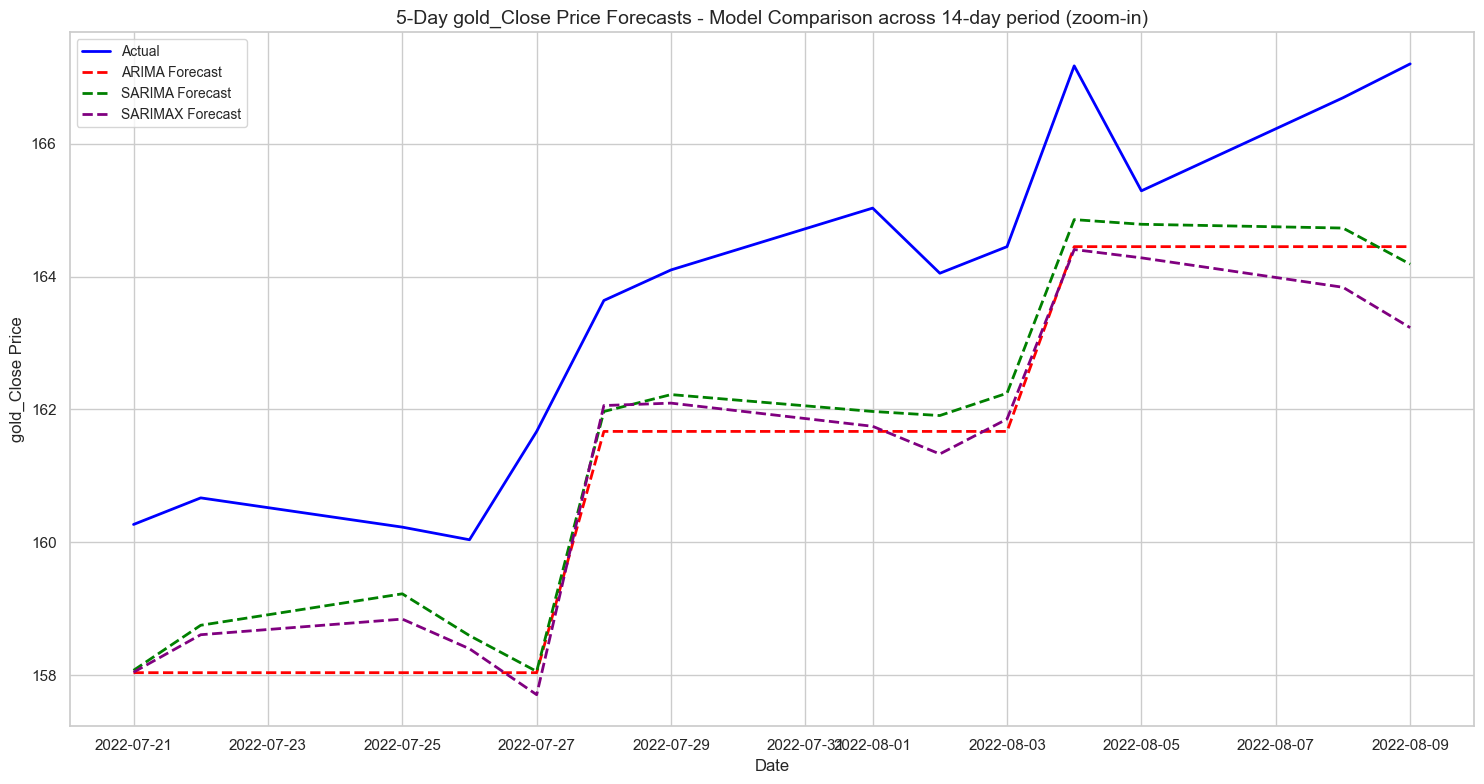

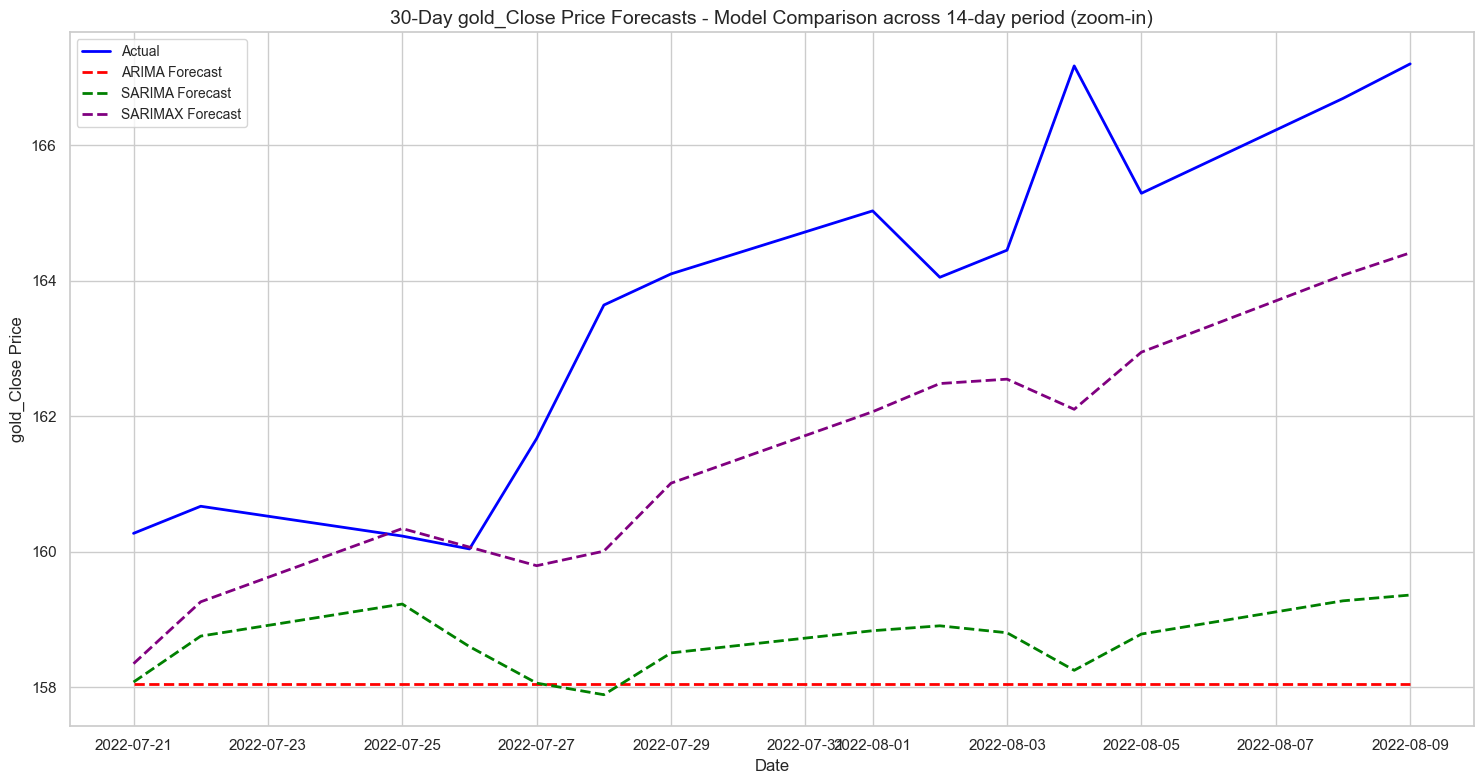

In [46]:
period_to_check = 14

# Create comparison plots for each horizon
colors = {'ARIMA': 'red', 'SARIMA': 'green', 'SARIMAX': 'purple'}
_, true_test_df = slice_data(full_df, 0, int(len(all_data) * 0.8), len(all_data))

for horizon in horizons:
    plt.figure(figsize=(15, 8))

    # Plot actual values
    actual = true_test_df[attribute_to_predict][:period_to_check]
    plt.plot(actual.index, actual.values, label='Actual', color='blue', linewidth=2)

    # Load and plot forecasts
    for model, color in colors.items():
        forecast_data = all_forecasts_dict[horizon][model][:period_to_check]
        plt.plot(forecast_data.index, forecast_data.values,
                label=f'{model} Forecast',
                color=color,
                linestyle='--',
                linewidth=2)

    plt.title(f'{horizon}-Day {attribute_to_predict} Price Forecasts - Model Comparison across {period_to_check}-day period (zoom-in)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{attribute_to_predict} Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Model Performance Analysis
Calculating and comparing error metrics across models and horizons.

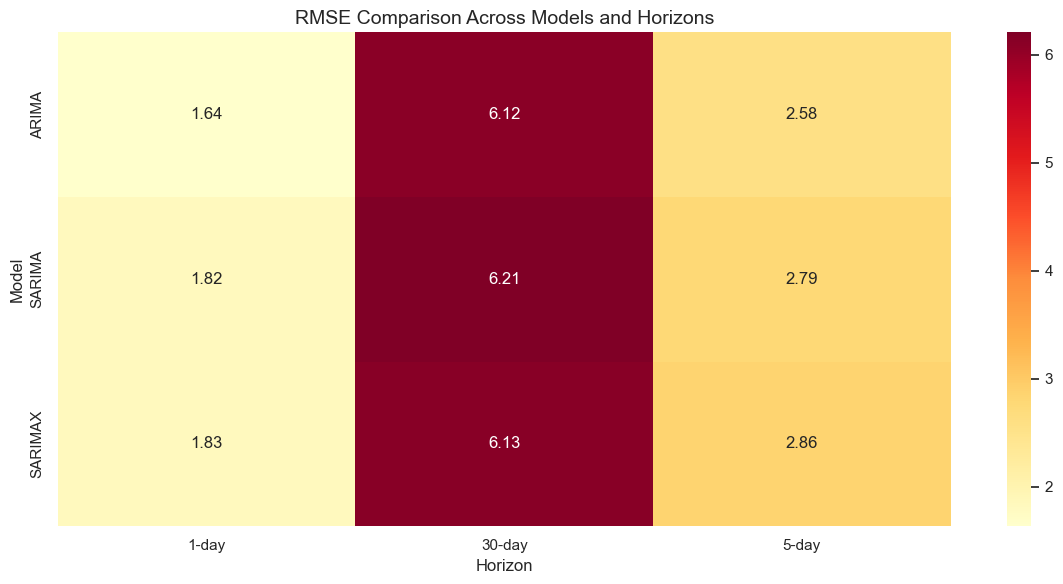

Detailed Error Metrics by Model and Horizon:
  Model Horizon       MSE     RMSE      MAE
  ARIMA   1-day  2.677677 1.636361 1.185777
 SARIMA   1-day  3.321687 1.822550 1.355715
SARIMAX   1-day  3.339619 1.827463 1.363587
  ARIMA   5-day  6.656027 2.579928 1.911755
 SARIMA   5-day  7.795291 2.792005 2.089843
SARIMAX   5-day  8.206607 2.864718 2.160987
  ARIMA  30-day 37.440450 6.118860 4.532141
 SARIMA  30-day 38.553584 6.209153 4.608461
SARIMAX  30-day 37.608782 6.132600 4.594442


In [47]:
# Calculate and compare error metrics
metrics_data = []

for horizon in horizons:
    actual = true_test_df[attribute_to_predict]

    for model in ['ARIMA', 'SARIMA', 'SARIMAX']:
        forecast_data = all_forecasts_dict[horizon][model]

        mse = mean_squared_error(actual[:len(forecast_data)], forecast_data)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual[:len(forecast_data)], forecast_data)

        metrics_data.append({
            'Model': model,
            'Horizon': f'{horizon}-day',
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae
        })

metrics_df = pd.DataFrame(metrics_data)

# Create heatmap of RMSE values
plt.figure(figsize=(12, 6))
rmse_pivot = metrics_df.pivot(index='Model', columns='Horizon', values='RMSE')
sns.heatmap(rmse_pivot, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('RMSE Comparison Across Models and Horizons', fontsize=14)
plt.tight_layout()
plt.show()

# Print detailed metrics
print("Detailed Error Metrics by Model and Horizon:")
print(metrics_df.to_string(index=False))